In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_train.csv


In [26]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count

from sklearn.metrics import classification_report , confusion_matrix


In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00','#FF7D00','#FF006D','#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=16,10

In [28]:
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [29]:
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')
y_train.head() # features that are labels

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


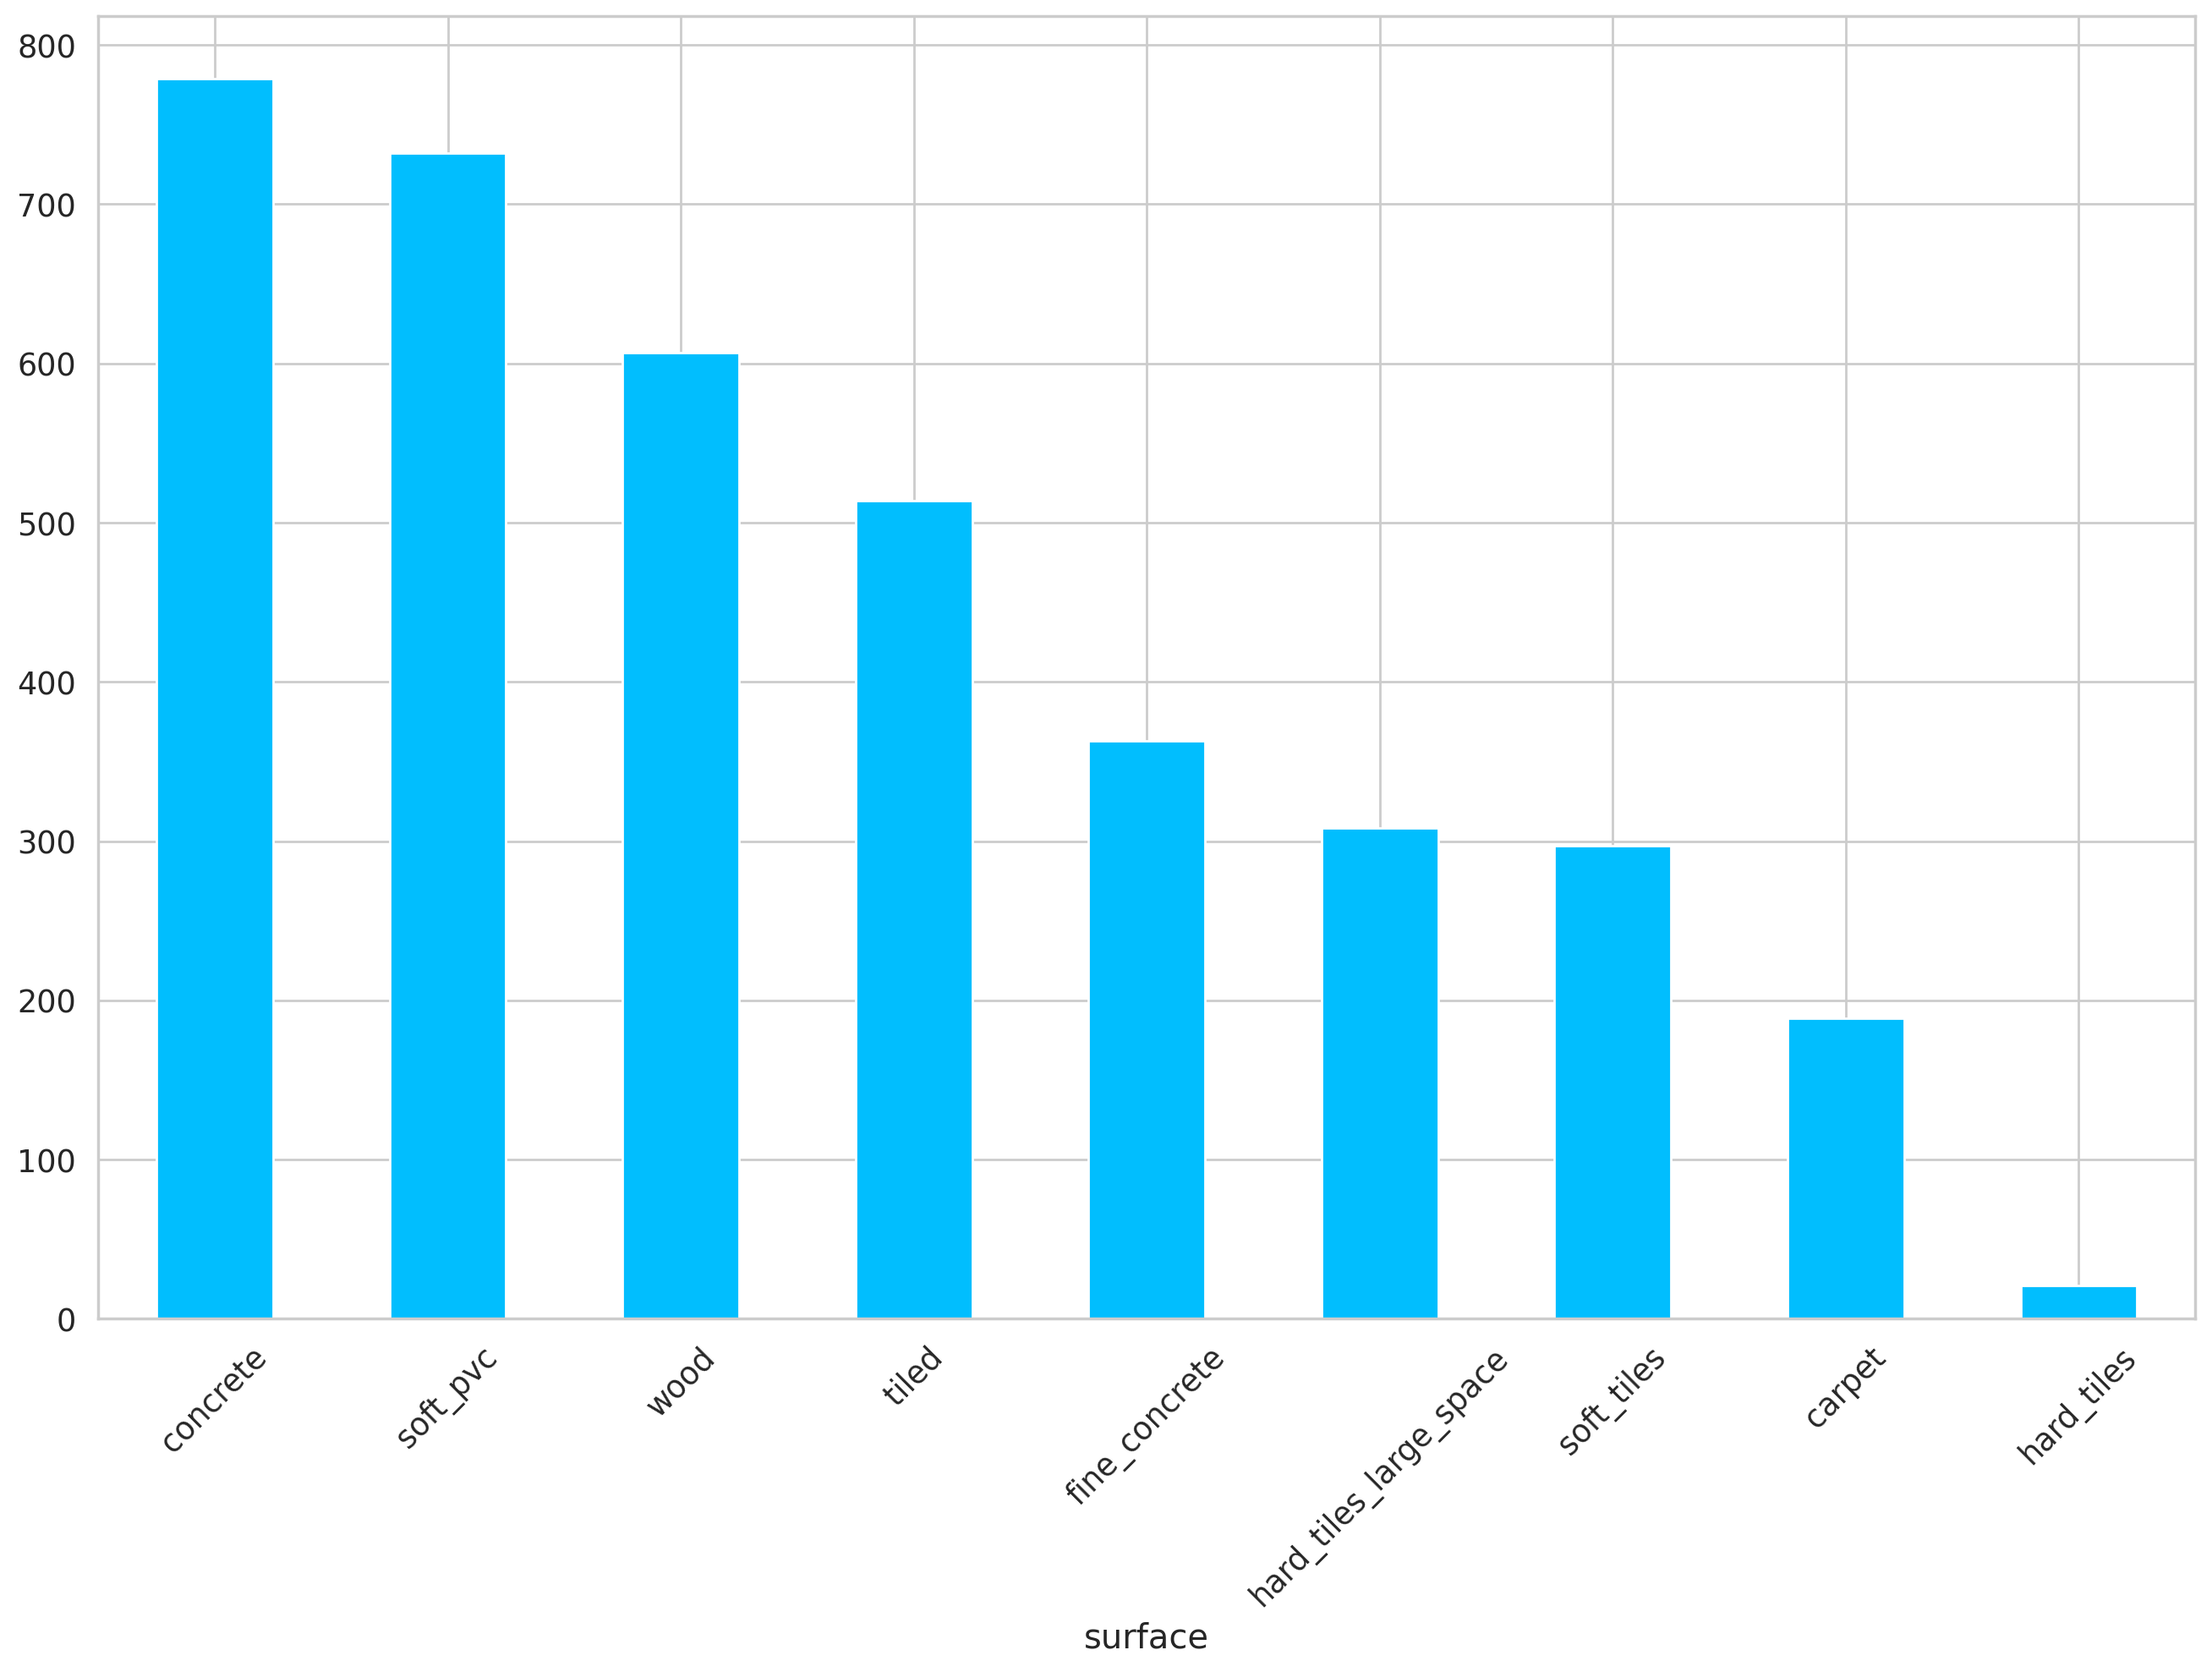

In [30]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

# Preprocessing to convert string values of surfaces to integers for neural network

In [31]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [32]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [33]:
#labels are stored in the classes_ property in label encoder
label_encoder.classes_
# to reverse transformation if and when needed

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [34]:
y_train["label"]=encoded_labels

In [35]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [36]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [37]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [38]:
(X_train.series_id.value_counts()==128).sum() == len(y_train)
# check that all the sequences have 128 of series ids (grouped datapoints for each time step)

True

In [39]:
# group by series_id

sequences = []

for series_id , group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id== series_id].iloc[0].label

    sequences.append((sequence_features,label ))
    

In [40]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [41]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

len(train_sequences) , len(test_sequences)

(3048, 762)

In [42]:
class SurfaceDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequence , label = self.sequences[idx]
        return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [43]:
from torch.utils.data import DataLoader
from multiprocessing import cpu_count

class SurfaceDataLoader:
    
    def __init__(self, train_sequences, test_sequences, batch_size):
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        self.setup()
        
    def setup(self):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
        
    def get_train_loader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def get_val_loader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def get_test_loader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )

# Parameters
N_EPOCHS = 250
BATCH_SIZE = 64

# Instantiate the data loader
data_loader = SurfaceDataLoader(train_sequences, test_sequences, BATCH_SIZE)

# Access loaders
train_loader = data_loader.get_train_loader()
val_loader = data_loader.get_val_loader()
test_loader = data_loader.get_test_loader()


# MODEL

In [44]:
class SequenceModel(nn.Module):
    # classification, number of hidden units, number of layers for LSTM
    
    def __init__(self, n_features, n_classes , n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first=True,
        dropout=0.75)
        
        self.classifier = nn.Linear(n_hidden , n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

# Without Early Stopping

In [45]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchmetrics import Accuracy
# import matplotlib.pyplot as plt

# class SurfacePredictor(nn.Module):
#     def __init__(self,n_features:int,n_classes:int):
#         super(SurfacePredictor, self).__init__()
#         self.model = SequenceModel(n_features, n_classes)
#         self.criterion = nn.CrossEntropyLoss()
#         self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)
        
#         # Initialize lists to store metrics for each epoch
#         self.epoch_train_losses = []
#         self.epoch_val_losses = []
#         self.epoch_train_accuracies = []
#         self.epoch_val_accuracies = []
        
#     def forward(self, x):
#         return self.model(x)
    
#     def compute_loss_and_accuracy(self, outputs, labels):
#         loss = self.criterion(outputs, labels)
#         predictions = torch.argmax(outputs, dim=1)
#         accuracy = self.accuracy_metric(predictions, labels)
#         return loss, accuracy
        
        
#     def plot_metrics(self):
#         # Ensure both training and validation metrics have the same length
#         num_epochs = min(len(self.epoch_train_losses), len(self.epoch_val_losses))
#         epochs = range(1, num_epochs + 1)
        
#         # Adjust the lists to the same length for consistent plotting
#         train_losses = self.epoch_train_losses[:num_epochs]
#         val_losses = self.epoch_val_losses[:num_epochs]
#         train_accuracies = self.epoch_train_accuracies[:num_epochs]
#         val_accuracies = self.epoch_val_accuracies[:num_epochs]
        
#         plt.figure(figsize=(12, 5))
        
#         # Plot Loss
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, train_losses, 'b', label='Training Loss')
#         plt.plot(epochs, val_losses, 'r', label='Validation Loss')
#         plt.title('Training and Validation Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
        
#         # Plot Accuracy
#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
#         plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
#         plt.title('Training and Validation Accuracy')
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracy')
#         plt.legend()
        
#         plt.tight_layout()
#         plt.show()
#     # Training and validation loop

#     def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001):
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         for epoch in range(num_epochs):
#             # Training phase
#             model.train()
#             train_losses = []
#             train_accuracies = []

#             for batch in train_loader:
#                 sequences = batch["sequence"]
#                 labels = batch["label"]

#                 optimizer.zero_grad()
#                 outputs = model(sequences)
#                 loss, accuracy = model.compute_loss_and_accuracy(outputs, labels)

#                 loss.backward()
#                 optimizer.step()

#                 train_losses.append(loss.item())
#                 train_accuracies.append(accuracy.item())

#             avg_train_loss = sum(train_losses) / len(train_losses)
#             avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)

#             # Validation phase
#             model.eval()
#             val_losses = []
#             val_accuracies = []

#             with torch.no_grad():
#                 for batch in val_loader:
#                     sequences = batch["sequence"]
#                     labels = batch["label"]

#                     outputs = model(sequences)
#                     loss, accuracy = model.compute_loss_and_accuracy(outputs, labels)

#                     val_losses.append(loss.item())
#                     val_accuracies.append(accuracy.item())

#             avg_val_loss = sum(val_losses) / len(val_losses)
#             avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

#             # Store epoch metrics for plotting
#             model.epoch_train_losses.append(avg_train_loss)
#             model.epoch_val_losses.append(avg_val_loss)
#             model.epoch_train_accuracies.append(avg_train_accuracy)
#             model.epoch_val_accuracies.append(avg_val_accuracy)

#             # Print metrics
#             print(f"Epoch {epoch + 1}/{num_epochs}")
#             print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")
#             print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

#         # Plot training and validation metrics
#         model.plot_metrics()
        

        

# With Early Stopping

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

class SurfacePredictor(nn.Module):
    def __init__(self, n_features: int, n_classes: int):
        super(SurfacePredictor, self).__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)
        
        # Initialize lists to store metrics for each epoch
        self.epoch_train_losses = []
        self.epoch_val_losses = []
        self.epoch_train_accuracies = []
        self.epoch_val_accuracies = []        
        
    def forward(self, x):
        return self.model(x)    
        
    def compute_loss_and_accuracy(self, outputs, labels):
        loss = self.criterion(outputs, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = self.accuracy_metric(predictions, labels)
        return loss, accuracy
    
    def plot_metrics(self):
        # Ensure both training and validation metrics have the same length
        num_epochs = min(len(self.epoch_train_losses), len(self.epoch_val_losses))
        epochs = range(1, num_epochs + 1)
        
        # Adjust the lists to the same length for consistent plotting
        train_losses = self.epoch_train_losses[:num_epochs]
        val_losses = self.epoch_val_losses[:num_epochs]
        train_accuracies = self.epoch_train_accuracies[:num_epochs]
        val_accuracies = self.epoch_val_accuracies[:num_epochs]
        
        plt.figure(figsize=(12, 5))    
        
        
        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'b', label='Training Loss')
        plt.plot(epochs, val_losses, 'r', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
        plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend() 

        plt.tight_layout()
        plt.show()    
        

# Train without early stopping

In [47]:
# import torch
# from torch.utils.tensorboard import SummaryWriter
# import os

# # Parameters
# N_EPOCHS = 250
# BATCH_SIZE = 64
# PATIENCE = 10 # for early stopping
# CHECKPOINT_DIR = "checkpoints"
# LOG_DIR = "lightning_logs/surface"
# BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best-checkpoint.pth")

# # Ensure directories exist
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# # Instantiate TensorBoard writer
# writer = SummaryWriter(LOG_DIR)

# # Function to save the model checkpoint
# def save_checkpoint(model, optimizer, epoch, val_loss, best_val_loss):
#     # Only save the model if the current val_loss is better than the best_val_loss
#     if val_loss < best_val_loss:
#         print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': val_loss,
#         }, BEST_MODEL_PATH)
#         return val_loss
#     return best_val_loss

# # Training loop
# def train(model, train_loader, val_loader, criterion, optimizer):
#     best_val_loss = float('inf')

#     for epoch in range(1, N_EPOCHS + 1):
#         model.train()
#         train_loss = 0.0
#         train_correct = 0
#         train_total = 0
        
#         # Training step
#         for batch in train_loader:
#             sequences, labels = batch["sequence"].to(device), batch["label"].to(device)
#             optimizer.zero_grad()
#             outputs = model(sequences)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item() * sequences.size(0)
#             train_correct += (outputs.argmax(1) == labels).sum().item()
#             train_total += labels.size(0)
        
#         avg_train_loss = train_loss / train_total
#         train_accuracy = train_correct / train_total
        
#         # Validation step
#         model.eval()
#         val_loss = 0.0
#         val_correct = 0
#         val_total = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 sequences, labels = batch["sequence"].to(device), batch["label"].to(device)
#                 outputs = model(sequences)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * sequences.size(0)
#                 val_correct += (outputs.argmax(1) == labels).sum().item()
#                 val_total += labels.size(0)
                
#         avg_val_loss = val_loss / val_total
#         val_accuracy = val_correct / val_total

#         # Logging to TensorBoard
#         writer.add_scalar("Loss/Train", avg_train_loss, epoch)
#         writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
#         writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
#         writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

#         # Print metrics
#         print(f"Epoch {epoch}/{N_EPOCHS}, "
#               f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
#               f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
#         # save metrics to model for plotting
#         model.epoch_train_losses.append(avg_train_loss)
#         model.epoch_train_accuracies.append(train_accuracy)
#         model.epoch_val_losses.append(avg_val_loss)
#         model.epoch_val_accuracies.append(val_accuracy)
        
        
#         # Save checkpoint
#         best_val_loss = save_checkpoint(model, optimizer, epoch, avg_val_loss, best_val_loss)

#     writer.close()

# # Example usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model = SurfacePredictor(n_features, n_classes).to(device)
# model = SurfacePredictor(n_features = len(FEATURE_COLUMNS),n_classes = len(label_encoder.classes_)).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = torch.nn.CrossEntropyLoss()

# data_loader = SurfaceDataLoader(train_sequences, test_sequences, BATCH_SIZE)
# train_loader = data_loader.get_train_loader()
# val_loader = data_loader.get_val_loader()

# # Train the model
# train(model, train_loader, val_loader, criterion, optimizer)

# # Plot metrics
# model.plot_metrics()


# Train with early stopping

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/250, Train Loss: 2.1283, Train Accuracy: 0.1850, Val Loss: 2.0174, Val Accuracy: 0.2073
Validation loss improved from inf to 2.0174. Saving model...
Epoch 2/250, Train Loss: 2.0196, Train Accuracy: 0.1896, Val Loss: 2.0008, Val Accuracy: 0.2192
Validation loss improved from 2.0174 to 2.0008. Saving model...
Epoch 3/250, Train Loss: 2.0145, Train Accuracy: 0.2008, Val Loss: 1.9983, Val Accuracy: 0.2021
Validation loss improved from 2.0008 to 1.9983. Saving model...
Epoch 4/250, Train Loss: 2.0119, Train Accuracy: 0.2011, Val Loss: 1.9949, Val Accuracy: 0.2336
Validation loss improved from 1.9983 to 1.9949. Saving model...
Epoch 5/250, Train Loss: 1.9969, Train Accuracy: 0.2405, Val Loss: 1.9614, Val Accuracy: 0.2612
Validation loss improved from 1.9949 to 1.9614. Saving model...
Epoch 6/250, Train Loss: 1.9532, Train Accuracy: 0.2536, Val Loss: 1.9362, Val Accuracy: 0.2703
Validation loss improved from 1.9614 to 1.9362. Saving model...
Epoch 7/250, Train Loss: 2.0155, Train Accu

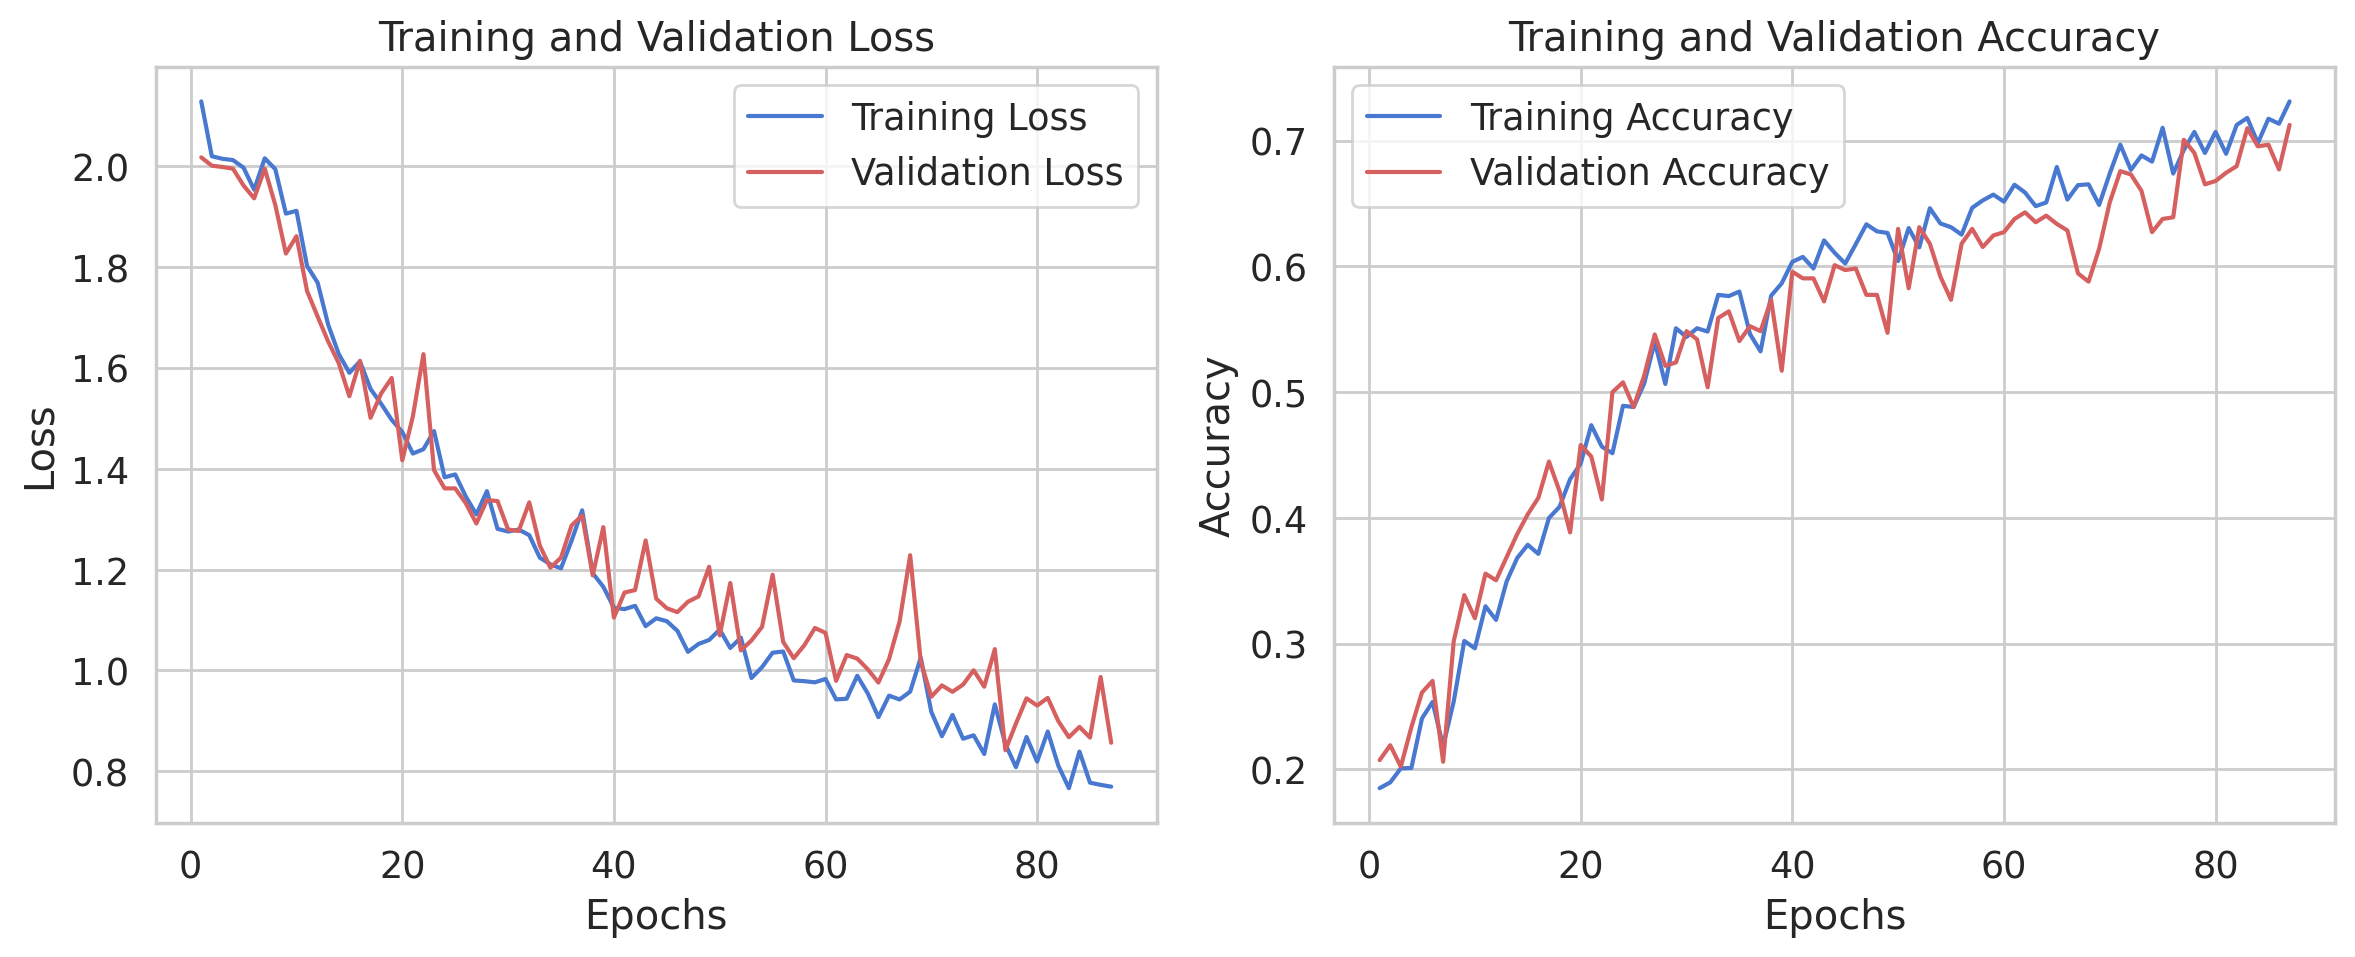

In [48]:
import torch
from torch.utils.tensorboard import SummaryWriter
import os

# Parameters
N_EPOCHS = 250
BATCH_SIZE = 64
PATIENCE = 10 # for early stopping
CHECKPOINT_DIR = "checkpoints"
LOG_DIR = "lightning_logs/surface"
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best-checkpoint.pth")

# Ensure directories exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Instantiate TensorBoard writer
writer = SummaryWriter(LOG_DIR)

def save_checkpoint(model, optimizer, epoch, val_loss, best_val_loss, BEST_MODEL_PATH):
    # Only save the model if the current val_loss is better than the best_val_loss
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, BEST_MODEL_PATH)
        return val_loss
    return best_val_loss

def train(model, train_loader, val_loader, criterion, optimizer, BEST_MODEL_PATH, patience=10, num_epochs=250):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Training step
        for batch in train_loader:
            sequences, labels = batch["sequence"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * sequences.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                sequences, labels = batch["sequence"].to(device), batch["label"].to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * sequences.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
                
        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total

        # Logging
        print(f"Epoch {epoch}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # Save metrics to model for plotting
        model.epoch_train_losses.append(avg_train_loss)
        model.epoch_train_accuracies.append(train_accuracy)
        model.epoch_val_losses.append(avg_val_loss)
        model.epoch_val_accuracies.append(val_accuracy)
        
        # Save checkpoint if validation loss improves
        new_best_loss = save_checkpoint(model, optimizer, epoch, avg_val_loss, best_val_loss, BEST_MODEL_PATH)
        
        # Early stopping logic
        if new_best_loss < best_val_loss:
            best_val_loss = new_best_loss
            epochs_without_improvement = 0  # Reset counter if improvement
        else:
            epochs_without_improvement += 1  # Increment counter if no improvement
        
        # Check if early stopping criteria is met
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch} epochs with no improvement in validation loss.")
            break

    # Plot training and validation metrics
    model.plot_metrics()

# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SurfacePredictor(n_features=len(FEATURE_COLUMNS), n_classes=len(label_encoder.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

data_loader = SurfaceDataLoader(train_sequences, test_sequences, BATCH_SIZE)
train_loader = data_loader.get_train_loader()
val_loader = data_loader.get_val_loader()
BEST_MODEL_PATH = "best-checkpoint.pth"

# Train the model with early stopping
train(model, train_loader, val_loader, criterion, optimizer, BEST_MODEL_PATH, patience=10, num_epochs=250)

# Load the Best Model Checkpoint

In [49]:
checkpoint= torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device) # Move the model to the appropriate device (CPU or GPU)
model.eval() # set model to evaluation mode

/tmp/ipykernel_30/119591299.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint= torch.load(BEST_MODEL_PATH)


SurfacePredictor(
  (model): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=9, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (accuracy_metric): MulticlassAccuracy()
)

# Perform Inference on New Data

In [50]:
# example of a single inference
def infer(model, data_loader):
    model.eval() # ensure model is in evaluation mode
    predictions = []
    with torch.no_grad(): # disable gradient tracking
        for batch in data_loader:
            sequences = batch["sequence"].to[device] # Load data to the same device as the model
            outputs = model(sequence)
            preds = outputs.argmax(dim=1) # Get the index of the highest score as the predicted class
            predictions.extend(preds.cpu().numpy()) # Collect predictions and move them to CPU if on GPU
            
    return predictions
 

# Running Inference

In [51]:
# Assuming `test_loader` is a DataLoader with the data for inference
test_loader = pd.read_csv('/kaggle/input/career-con-2019/X_test.csv')
predictions = infer(model, test_loader)
print("Predictions:", predictions)

TypeError: string indices must be integers